# 🧠 Train ElasticNet on Drug Response with Pseudo-Bulk PCA

This notebook trains an ElasticNet regression model for each drug using PCA features extracted from pseudo-bulk expression profiles, and evaluates model performance using cross-validation.


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV


## 📥 Load Filtered Pseudo-Bulk + GDSC Dataset


In [2]:
NUM_PCS = 30  # match the number of pseudo PCs you used
DATA_PATH = "gdsc_pseudobulk_pca.parquet"

data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (102127, 34)


## 🧪 Select Only Pseudo-Bulk PCA Features


In [3]:
os.makedirs("results/elastic_net_pseudobulk", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50", "pseudo_source"]
feature_cols = [col for col in data.columns if col.startswith("PSEUDO_PC")]

# CV setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


## 🔁 Train ElasticNetCV per Drug with Cross-Validation


In [8]:
results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[feature_cols].values
    y = df["LN_IC50"].values

    model = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            alphas=[0.01, 0.1, 1.0, 10.0],
            l1_ratio=[0.1, 0.5, 0.9],
            cv=kf,
            max_iter=10000,  # increase iterations
            random_state=42
        )
    )

    model.fit(X, y)

    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "alpha": model.named_steps["elasticnetcv"].alpha_,
        "l1_ratio": model.named_steps["elasticnetcv"].l1_ratio_,
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })


## 💾 Save Results


In [9]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/elastic_net_pseudobulk/elasticnet_pseudobulk_{NUM_PCS}_pcs.csv", index=False)

print(f"📁 Saved to results/elastic_net_pseudobulk/elasticnet_pseudobulk_{NUM_PCS}_pcs.csv")
results_df.head()


📁 Saved to results/elastic_net_pseudobulk/elasticnet_pseudobulk_30_pcs.csv


,DRUG_ID,n_samples,alpha,l1_ratio,rmse_mean,rmse_std,r2_mean,r2_std
0,1,28,1.0,0.1,1.698755,0.434787,-2.654271,2.744781
1,3,27,10.0,0.1,1.698597,0.906545,-0.606547,0.800732
2,5,30,10.0,0.1,1.447488,0.246867,-0.896063,1.259433
3,6,32,10.0,0.1,0.504834,0.150599,-0.168678,0.236863
4,9,31,1.0,0.1,1.655827,0.558307,-0.724716,1.870932


## 📊 Visualize Cross-Validation Performance


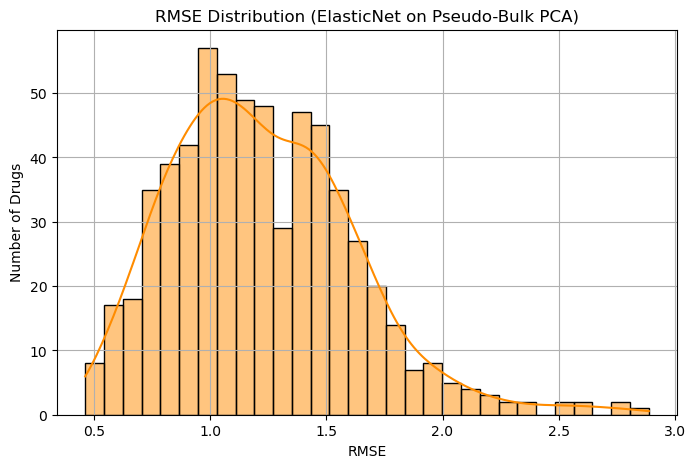

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution (ElasticNet on Pseudo-Bulk PCA)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/elastic_net_pseudobulk/elasticnet_rmse_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()


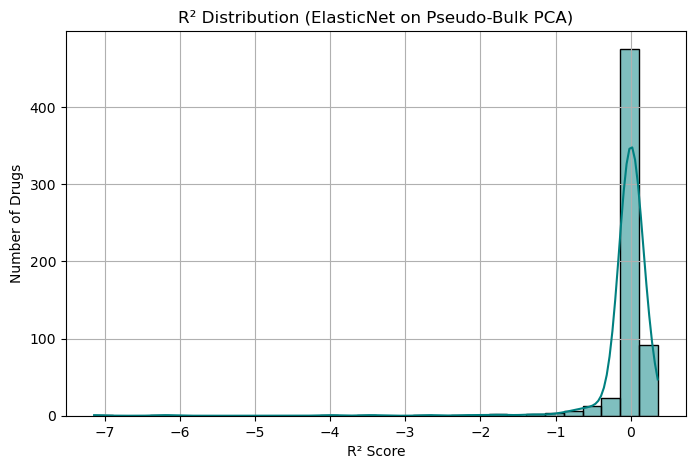

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution (ElasticNet on Pseudo-Bulk PCA)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/elastic_net_pseudobulk/elasticnet_r2_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()
